## Finding Fourier Coefficients

In [ ]:
import numpy as np
from scipy.integrate import nquad
from concurrent.futures import ProcessPoolExecutor
import auxfunctions as aux
import matplotlib.pyplot as plt

# Define the functions and parameters
a = 3.66
b = 1.75
c = 0.45
A = 0

# Define the range of coefficients to compute
nMax = 16
mMax = 16

n_vec = np.arange(nMax)
m_vec = np.arange(mMax)
n_grid, m_grid = np.meshgrid(n_vec, m_vec, indexing='ij')
k_nm = np.pi * np.sqrt((n_grid / a)**2 + (m_grid / b)**2)

def integrand1(x, y, n, m):
    return 0.15 * aux.cyc_pertub(x, y) * np.cos(n * np.pi * x / a) * np.cos(m * np.pi * y / b)

# Initialize coefficients array
coefficients1 = np.zeros((nMax, mMax))

# Define the integration limits as tuples
x_limits = (-a, a)
y_limits = (-b, b)

# Function to compute a single coefficient
def compute_coefficient(args):
    n, m = args
    result1, _ = nquad(lambda x, y, n=n, m=m: integrand1(x, y, n, m), [x_limits, y_limits])
    # Modify coefficients based on conditions
    if n == 0 and m == 0:
        result1 /= (4 * a * b)
    elif n == 0 or m == 0:
        result1 /= (2 * a * b)
    else:
        result1 /= (a * b)
    return n, m, result1

# Use ProcessPoolExecutor for parallelization
with ProcessPoolExecutor() as executor:
    results = list(executor.map(compute_coefficient, [(n, m) for n in range(nMax) for m in range(mMax)]))

# Update the coefficients based on the results
for n, m, result1 in results:
    coefficients1[n, m] = result1

# Define the original function
def originalFunction(x, y):
    return 0.15 * aux.cyc_pertub(x, y)

# Define the reconstructed function using the computed coefficients
def reconstructedFunction(x, y):
    result = 0
    for n in range(0, nMax):
        for m in range(0, mMax):
            result += coefficients1[n, m] * np.cos(n * np.pi * x / a) * np.cos(m * np.pi * y / b)
    return result

# Create a grid for plotting
x_grid, y_grid = np.meshgrid(np.linspace(-a, a, 100), np.linspace(-b, b, 100))

# Evaluate the functions on the grid
z_original = originalFunction(x_grid, y_grid)
z_reconstructed = reconstructedFunction(x_grid, y_grid)

# Plot the contour plots
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.contourf(x_grid, y_grid, z_original, cmap='viridis')
plt.title('Original Function')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.contourf(x_grid, y_grid, z_reconstructed, cmap='viridis')
plt.title('Reconstructed Function')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()

plt.tight_layout()
plt.show()

# Display the coefficients
print("n\tm\tCoefficientB")
for n in range(0, nMax):
    for m in range(0, mMax):
        print(f"{n}\t{m}\t{coefficients1[n, m]}")


## Code for Investigating if the Neumann Boundary Conditions have been Properly Applied

Solving linear variational problem.


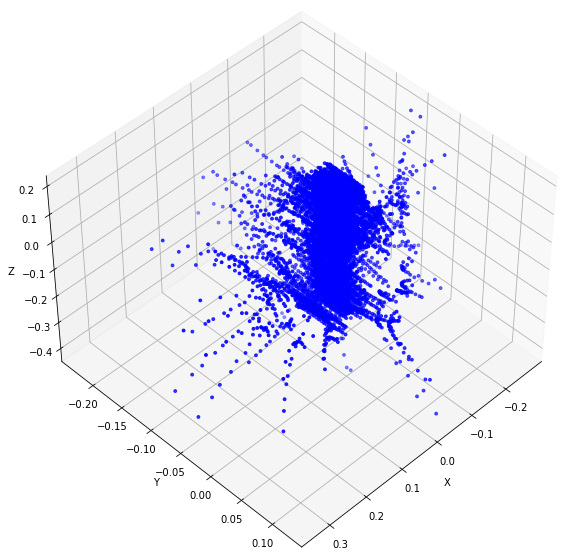

In [11]:
# from dolfin import *
# import matplotlib.pyplot as plt
# import numpy as np

# # Compute the gradient of u
# V_vec = VectorFunctionSpace(mesh, 'DG', 1)
# grad_u = project(grad(u), V_vec)

# # Function to extract and evaluate the z-component of the gradient
# def evaluate_dudz_on_plane(z_value, X, Y):
#     rows, cols = X.shape
#     dudz_values = np.zeros((rows, cols))
#     for i in range(rows):
#         for j in range(cols):
#             # Use X[i, j] and Y[i, j] to get the individual points
#             p = Point(X[i, j], Y[i, j], z_value)
#             dudz_values[i, j] = grad_u(p)[2]  # z-component of the gradient
#     return dudz_values

# # Create a regular 2D grid for the x-y plane
# x = np.linspace(-a, a, 100)
# y = np.linspace(-b, b, 100)
# X, Y = np.meshgrid(x, y)

# # Function to interpolate Phi_u on a specific z-plane
# def interpolate_on_plane(z_value, X, Y):
#     rows, cols = X.shape
#     values = np.zeros((rows, cols))
#     for i in range(rows):
#         for j in range(cols):
#             p = Point(X[i, j], Y[i, j], z_value)
#             values[i, j] = Phi_u(p)
#     return values

# # Interpolate data on the z=0 and z=c planes
# values_at_z0 = interpolate_on_plane(0, X, Y)
# values_at_zc = interpolate_on_plane(c, X, Y)
# # values_at_z0 = evaluate_dudz_on_plane(0, X, Y)
# # values_at_zc = evaluate_dudz_on_plane(c, X, Y)

# # Create contour plots with just the contour lines
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# # Plot 15 contours for z=0 plane
# contour1 = ax1.contour(X, Y, values_at_z0, levels=20)
# fig.colorbar(contour1, ax=ax1)
# ax1.set_title('Contour plot at z=0')
# ax1.set_xlabel('x')
# ax1.set_ylabel('y')

# # Plot 15 contours for z=c plane
# contour2 = ax2.contour(X, Y, values_at_zc, levels=20)
# fig.colorbar(contour2, ax=ax2)
# ax2.set_title(f'Contour plot at z={c}')
# ax2.set_xlabel('x')
# ax2.set_ylabel('y')

# plt.show()

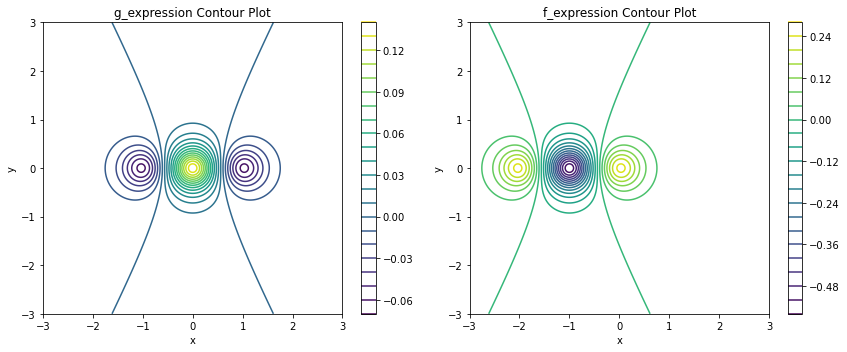

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def f_expression(x, y):
    return -0.6 * ((1 + ((x + 1)/0.5)**2 + (y/0.5)**2)**(-1.5) - \
           0.5 * ((1 + (x/0.5)**2 + (y/0.5)**2)**(-1.5) + \
           (1 + ((x + 2)/0.5)**2 + (y/0.5)**2)**(-1.5)))

def g_expression(x, y):
    return 0.15 * ((1 + (x / 0.5)**2 + (y / 0.5)**2)**(-1.5) - \
                   0.5 * ((1 + ((x - 1) / 0.5)**2 + (y / 0.5)**2)**(-1.5) + \
                   (1 + ((x + 1) / 0.5)**2 + (y / 0.5)**2)**(-1.5)))

# Create a grid of x and y values
x = np.linspace(-3, 3, 400)
y = np.linspace(-3, 3, 400)
X, Y = np.meshgrid(x, y)

# Evaluate expressions
Z_f = f_expression(X, Y)
Z_g = g_expression(X, Y)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Contour plot for f_expression
c1 = axes[0].contour(X, Y, Z_g, levels=20)
fig.colorbar(c1, ax=axes[0])
axes[0].set_title('g_expression Contour Plot')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')

# Contour plot for g_expression
c2 = axes[1].contour(X, Y, Z_f, levels=20)
fig.colorbar(c2, ax=axes[1])
axes[1].set_title('f_expression Contour Plot')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')

plt.tight_layout()
plt.show()